In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse.linalg import eigs
from utils import load_data
from JDA import JDA1
from mpl_toolkits import mplot3d

%load_ext autoreload
%autoreload 2

## JDA

We are choosing a kernel. [This paper](http://naotoyokoya.com/assets/pdf/JXiaIGARSS2017a.pdf) chooses RBF. 

The solution to the optimization problem is the [generalized eigendecomposition problem](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#:~:text=a%20coneigenvalue%20equation.-,Generalized%20eigenvalue%20problem,-%5Bedit%5D) 

#### Dummy dataset


In [3]:
def make_data(class1, class2, class3):
    df1 = pd.DataFrame(class1, columns=['d1', 'd2'])
    df1['class'] = [1] * len(df1)
    df2 = pd.DataFrame(class2, columns=['d1', 'd2'])
    df2['class'] = [2] * len(df2)
    df3 = pd.DataFrame(class3, columns=['d1', 'd2'])
    df3['class'] = [3] * len(df3)
    df = pd.concat([df1, df2, df3], ignore_index=True)
    return df

A1 = np.random.multivariate_normal((5, 5), [[1, 0], [0, 0.25]], 50)
A2 = np.random.multivariate_normal((5, -8), [[0.1, 0], [0, 5]], 50)
A3 = np.random.multivariate_normal((-5, -8), [[0.5, 0.8], [0.8, 3]], 50)

S = make_data(A1, A2, A3)

# target set is made by shifting the coordinates by a constant -- simulating the distribution in the paper
# T = S[['d1', 'd2']] + np.ones(S[['d1', 'd2']].shape) * 50
# T.columns = ['d1', 'd2']
# T['class'] = S['class']

def rot_matrix(angle):
    return np.array(
        [[np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]])


theta = np.pi/2
T = (rot_matrix(theta) @ S[['d1', 'd2']].T).T
T.columns = ['d1', 'd2']
T['class'] = S['class']
S_T = pd.concat([S, T], ignore_index=True)

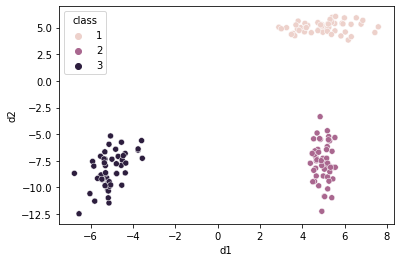

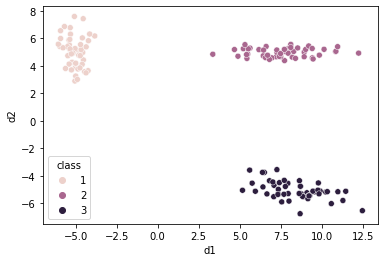

In [4]:
sns.scatterplot(data = S, x = 'd1', y='d2', hue='class')
plt.show()
sns.scatterplot(data = T, x = 'd1', y='d2', hue='class')
plt.show()

In [ ]:
S_T = pd.concat([S, T], ignore_index=True)

jda = JDA1(n_iter=20, mu=0.05, gamma = 0.1, top_k=2, neighbors=10, final_dict={'random_state':0}, final_classifier='rf')
Z = jda.fit(S.loc[:, "d1":"d2"], S['class'], T.loc[:, "d1":"d2"], T['class'])

Z_plot = pd.DataFrame(Z)
# plot the resulting feature space
Z_plot = Z_plot.loc[:, :4]
Z_plot['class'] = S_T['class']
domain_ = ['S'] * int((jda.len_s)) + ['T'] * int((jda.len_t))
Z_plot['domain'] = domain_


g = sns.PairGrid(Z_plot, hue="class", palette = ['blue', 'red', 'green'])
g.map_diag(sns.histplot, fill = None)
g.map_offdiag(sns.scatterplot, style=Z_plot["domain"], alpha = 0.5)
g.add_legend(title="", adjust_subtitles=True)

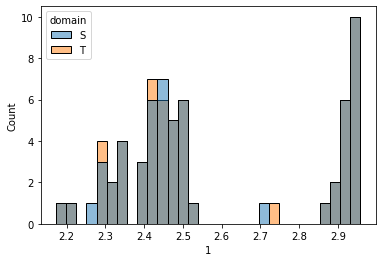

In [34]:
# Z_temp = Z.copy()
# Z_temp['domain'] = ['S'] * 60 + ['T'] * 60
# sns.histplot(Z_temp, x= 1, bins=30, hue='domain')
# sns.histplot(Z_temp, x= 'Z2', bins=30, hue='domain')

### A (source) to B (target)

In [ ]:
# get the data
S1, T1 = load_data(source_beam='A', target_beam = 'B', damage_levels = [0, 1], loc=1)
S_T1 = pd.concat([S1, T1], ignore_index=True)

https://machinelearningmastery.com/plot-a-decision-surface-for-machine-learning/

In [ ]:
jda = JDA1(n_iter=10, mu=100, gamma =5, top_k=5, neighbors=10, print_final = False, print=True)
Z = jda.fit(S1.loc[:, "d1":"d9"], S1['class'], T1.loc[:, "d1":"d9"], T1['class'])

# plot the resulting feature space
Z_plot = pd.DataFrame(Z)
Z_plot = Z_plot.loc[:, :4] # limit the plot to first 4 dimensions -- remove to plot all dimensions
Z_plot['class'] = S_T1['class']
domain_ = ['S'] * int((jda.len_s)) + ['T'] * int((jda.len_t))
Z_plot['domain'] = domain_

g = sns.PairGrid(Z_plot[Z_plot['domain'] == 'S'], hue="class", palette = ['blue', 'red'])
g.map_diag(sns.histplot, fill = None)
g.map_offdiag(sns.scatterplot, style=Z_plot[Z_plot['domain'] == 'S']["domain"], alpha = 0.5)
g.add_legend(title="", adjust_subtitles=True)